<a href="https://colab.research.google.com/github/ShamikaD/36-350/blob/main/Copy_of_Homework3_CBGT_and_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/CoAxLab/BiologicallyIntelligentExploration/blob/main/Homework/Homework3-CBGT_and_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 3: CBGT decision-making and information concepts**

## Getting started

This homework will involve concepts from the labs we've gone over in class. Feel free to reference them as you complete the assignment.

This homework contains 2 sections:
1. Simulating decisions in the CBGT network uner stronger direct vs indirect pathway gain.
1. Investigating information-seeking agents in environments of varying information noise.

Fill out the code cells below and answer the questions to complete the assignment. Most of the programming is quite straightforward, as it is all based on code from the labs, which you can use/modify in this notebook.


---
## Part 1 - CBGT decision simulations [51 pt]

Here you will be adapting the Lab 5 code so that you increase the indirect *and* direct pathways gains by 33% (we did 10% in class). This will give a clearer visualization of how these two pathways control the overall reaction times when you plot their joint histogram.


In the code cells below, fill in (and run) code according to the text instructions before each one. Refer to lab 5 for help.

#### Change Colab's working directory to the `/content` folder using the `cd` command

In [1]:
cd /content

/content


#### Clone in the CBGT library from https://github.com/CoAxLab/CBGT

In [2]:
!git clone https://github.com/CoAxLab/CBGT

Cloning into 'CBGT'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 592 (delta 1), reused 0 (delta 0), pack-reused 581
Receiving objects: 100% (592/592), 13.84 MiB | 18.89 MiB/s, done.
Resolving deltas: 100% (313/313), done.


#### Change Colab's working directory to the `/content/CBGT` folder

In [3]:
cd /content/CBGT

/content/CBGT


#### Import the necessary modules

In [4]:
# import libraries and configure plots

import os, sys
import pandas as pd
import numpy as np
import random
from future.utils import listvalues
from copy import deepcopy

import cbgt.netgen as ng
import cbgt.analyzefx as afx
from cbgt import vis, sim

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")

%matplotlib inline
clrs = ['#347fff', '#febe08']
eclrs = ['#1657de', '#f5a005']

rc = {'lines.solid_capstyle': u'butt'}
sns.set(style='ticks', rc=rc, font_scale=1.4)

#### Specify the saving directory and set default model parameters/weights exactly as we did in the CBGT lab.

In [5]:
# specify saving directory

parentDir = 'cbgtDemoTEST'
savedir = os.path.join(os.path.expanduser('~'), parentDir)
if not os.path.isdir(savedir):
    os.mkdir(savedir)

# specify certain model parameters

BaseStim = 0
Stim = 2.54
Dynamic = 30.0
Choices = 2
rampingCTX = True
popscale = .3
Start=200

# save dMSN/iMSN weight presets for each choice

presetLow = ng.set_post_learning_weights(dMSN=[1.01, 0.99], iMSN=[1.0,1.0])
presetHi = ng.set_post_learning_weights(dMSN=[1.03, 0.98], iMSN=[1.0,1.0])
presets = [presetLow, presetHi]

conds = ['low', 'high']
condABC = ['a', 'b']
cond12 = [1, 2]

savedirs = [os.path.join(savedir, c) for c in conds]
saveLow, saveHi = savedirs
saveTest=os.path.join(savedir, 'test')

presetDict = dict(zip(conds, presets))
condOrder = dict(zip(conds, condABC))
condLevel = dict(zip(conds+['test'], cond12+[0]))

#### Define the helping functions for getting sampling parameters, sampling region activations, and building a single network.

In [23]:
# helper functions to specify connection efficiacies for certain pathways

def get_sampling_params(scale, direct_strength, indirect_strength):
    
    # set strengths of background inputs/currents
    CxSTR      =    0.2
    CxTh       =    0.03
    CxFSI      =    0.165
    D1STR_GPi  =    direct_strength * 1.10
    D2STR_GPeP =    indirect_strength * 1.65
    STN_GPeP_A =    0.07
    STN_GPeP_N =    4.01
    STN_GPi    =    0.04
    GPi_Th     =    0.067
    ThSTR      =    0.34
    ThCx       =    0.02

    mu = dict(Cx={'STR':CxSTR, 'Th':CxTh, 'FSI':CxFSI}, 
                Th={'STR':ThSTR, 'Cx':ThCx},
                D1STR={'GPi': D1STR_GPi},
                D2STR={'GPeP': D2STR_GPeP},
                STN={'GPi': STN_GPi},
                GPi={'Th': GPi_Th})
    sd = {i:{j: mu[i][j]*scale for j in list(mu[i])} for i in list(mu)}
    return mu, sd

# assign the background inputs to each brain region accordingly
def sample_network_efficacies(muEff, sdEff, N):
    X = {}
    nuclei = list(muEff)
    for i in nuclei:
        targets = list(muEff[i])
        X[i] = {}
        for j in targets:
            X[i][j] = np.random.normal(muEff[i][j], sdEff[i][j], N)
    return X

# build the network with specified connections
def build_single_network(X, idx=0):
    
    Cx={'STR': X['Cx']['STR'][idx], 
        'Th': X['Cx']['Th'][idx], 
        'FSI': X['Cx']['FSI'][idx]}
    
    D1STR={'GPi': X['D1STR']['GPi'][idx]}
    D2STR={'GPeP': X['D2STR']['GPeP'][idx]}
    
    STN={'GPi': X['STN']['GPi'][idx]}
    
    GPi={'Th': X['GPi']['Th'][idx]}
    
    Th={'STR': X['Th']['STR'][idx], 
        'Cx': X['Th']['Cx'][idx]}

    return ng.getConEff(Cx=Cx, D1STR=D1STR, D2STR=D2STR, STN=STN, GPi=GPi, Th=Th)

#### Code for defining the function for running a batch of simulations.

In [24]:
# code to run a batch of simulations

def runBatch(batch_size, direct_strength, indirect_strength, parallel = 1):
  N_subj = 1
  sdScale = 0

  conProb = ng.getConProb()
  muEff, sdEff = get_sampling_params(sdScale, direct_strength, indirect_strength)
  X = sample_network_efficacies(muEff, sdEff, N=N_subj)
  subj_eff_dicts = [build_single_network(X, idx=i) for i in range(N_subj)]
  idx = 0
  conEff_i = subj_eff_dicts[idx]

  stim = 2.5
  preset = presetDict['low']

  ng.setDirectory(saveTest)

  np.random.seed(seed=np.random.randint(0,1000))
  sweepcount = ng.configureSweep(0, experiment='mc', preset=preset, Start=Start,
                                popscale=popscale, BaseStim=BaseStim, Choices=Choices, 
                                WrongStim=stim, RightStim=stim, Dynamic=Dynamic,
                                rampingCTX=True,
                                conProb=conProb, 
                                conEff=conEff_i)

  ng.compileAndRunSweepALL(batch_size, 0, 1, parallel)

#### Define the helper function for compiling simulated behavioral data into a dataframe.

In [25]:
# code to compile the behavioral data into a dataframe

def readResults(batch_size):
    results = ng.readAllTrialResults(batch_size,0,1)
    rtdata = pd.DataFrame(columns=['rt','accuracy'])
    for result in results[0][:batch_size]:
        temp = ng.findOutputs(result)['decision made']
        row = pd.Series({'rt':temp['delay'], 'accuracy':(1-temp['pathvals'][0])})
        rtdata = rtdata.append(row, ignore_index=True)
    return rtdata

### Code for running your specific batches of simulations

#### Set up your batch run parameters with a `batch_size` of 20, with `direct_strength` increased 33% from the default 1.00, and with the standard `indirect_strength` setting of 1.00. [7 pt]

In [26]:
def runBatch(batch_size = 20, direct_strength = 1.33, indirect_strength = 1.00, parallel = 1):
  N_subj = 1
  sdScale = 0

  conProb = ng.getConProb()
  muEff, sdEff = get_sampling_params(sdScale, direct_strength, indirect_strength)
  X = sample_network_efficacies(muEff, sdEff, N=N_subj)
  subj_eff_dicts = [build_single_network(X, idx=i) for i in range(N_subj)]
  idx = 0
  conEff_i = subj_eff_dicts[idx]

  stim = 2.5
  preset = presetDict['low']

  ng.setDirectory(saveTest)

  np.random.seed(seed=np.random.randint(0,1000))
  sweepcount = ng.configureSweep(0, experiment='mc', preset=preset, Start=Start,
                                popscale=popscale, BaseStim=BaseStim, Choices=Choices, 
                                WrongStim=stim, RightStim=stim, Dynamic=Dynamic,
                                rampingCTX=True,
                                conProb=conProb, 
                                conEff=conEff_i)

  ng.compileAndRunSweepALL(batch_size, 0, 1, parallel)


#### Run the strengthened direct pathway batch and produce a corresponding dataframe [7 pt]

In [27]:
runBatch()

# produce a dataframe with reaction times and accuracies
batch_size = 20
rt_data_direct = readResults(batch_size)
rt_data_direct

TypeError: ignored

#### Set up your batch run parameters with a `batch_size` of 20, the standard `direct_strength` of 1.00, but with `indirect_strength` increased by 33%. [7 pt]

In [18]:
# Your code here
batch_size = 20
direct_strength = 1.00
indirect_strength = 1.33

#### Run the strengthened indirect pathway batch and produce a corresponding dataframe [7 pt]

In [19]:
runBatch()

# produce a dataframe with reaction times and accuracies
rt_data_indirect = readResults(batch_size)
rt_data_indirect


,rt,accuracy
0,233.008026,1.0
1,230.007843,1.0
2,258.009552,1.0
3,284.011139,1.0
4,195.005707,1.0
5,234.008087,1.0
6,266.010040,1.0
7,260.009674,1.0
8,249.009003,1.0
9,258.009552,1.0


#### For each condition (strengthened direct vs indirect pathway), calculate and print the mean values for *reaction time* and *percent of actions made to the left* ("accuracy") [5 pt]

In [20]:
print("means for direct")
np.mean(rt_data_direct, axis = 0)

means for direct


rt          265.960037
accuracy      0.800000
dtype: float64

In [21]:
print("means for indirect")
np.mean(rt_data_indirect, axis = 0)

means for indirect


rt          251.009125
accuracy      0.700000
dtype: float64

#### Plot a histogram of reaction times for the strengthened direct vs. indirect pathway conditions. Make sure to refer to the correct data and include the correct data each time you call the `plt.hist()` function. [6 pt]

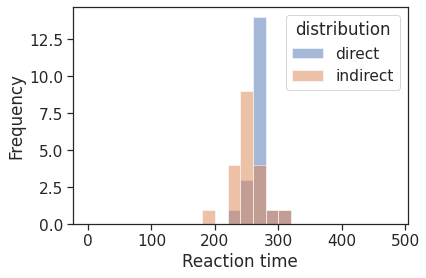

In [22]:
plt.hist(rt_data_direct.rt,  bins=np.arange(0,500,20), alpha=0.5, label='direct')
plt.hist(rt_data_indirect.rt, bins=np.arange(0,500,20), alpha=0.5, label='indirect')
plt.xlabel('Reaction time')
plt.ylabel('Frequency')
plt.legend(title='distribution')



### Question 1.1 [6 pt]

How what does increasing the relative efficacy of the direct and indirect pathways do to the networks' decision speed? Explain why this occurs.


In [12]:
# Increasing the relative efficacy of the direct slightly increases the network's decision speed. This makese sense because the direct pathway is excitatory and causes decitions to be made faster as less evidence is now needed to make a decition. Increasing the relative efficacy of the indirect slightly decreases the network's decision speed. This makese sense because the indirect pathway is inhibitory and causes decitions to be made slower as more evidence is now needed to make a decition. 


### Question 1.2: [6 pt]
Rerun the simulations above but increase the synaptic weight from STN to GPi from 0.0324 to 0.04. How does this influence the outcome of the simulations? Why does this happen?

(Hint: if you get an error while running the simulations, this is supposed to happen).

In [28]:
# This causes an error because the GPi is inhibitory to the thalamus. If we increase the weight to the GPi and inhibit the excitement of the thalapus too much, we will never reach a decition, so reaction time can not be recorded as the decition is never made.


---
## Part 2 - Exploration agents in information-distorted environments [49 pt]

In the last part of Lab 6 we saw how the distortion in the channel driven by *missing information* influenced the efficiency of our Info agent. In this second part of the homework, you will investigate the effect of distortion driven by *sensor noise*.

Here we will test a range of *noise_sigma* (as opposed to *p_scent*) values. Essentially we will be turning *up* the distortion as *noise_sigma* increases. For these experiments we will hold the *p_scent* constant at 0.1 (a sparse information environment).

### Coding

In the code cells below, fill in (and run) code according to the text instructions before each one. Refer to lab 6 for help.

#### Install relevant code libraries.

In [1]:
!pip install --upgrade git+https://github.com/coaxlab/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/coaxlab/explorationlib to /tmp/pip-req-build-3ihw9qyr
  Running command git clone -q https://github.com/coaxlab/explorationlib /tmp/pip-req-build-3ihw9qyr
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=24680 sha256=9f3912ffa635d1d82728f28150ac8131341d8640d5af7a42f75ff3d1f138cee0
  Stored in directory: /tmp/pip-ephem-wheel-cache-7i2sy6eh/wheels/33/38/07/7f61d2c279b8eed0cbef923c5315580ce93146145ca01ca407
Successfully built explorationlib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-ykrh7h7x
  Running command git clone -q https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-ykrh7h7x
     |████████████████████████████████| 21.8 MB 14.6 MB/s 
  Created wheel for gym-maze: filename=gym_maze

#### Import relevant modules.

In [2]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

import explorationlib
from explorationlib.local_gym import ScentGrid

from explorationlib.agent import DiffusionGrid
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import AccumulatorInfoGrid

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import add_noise
from explorationlib.local_gym import create_grid_scent_patches

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid
from explorationlib.plot import plot_targets2d

from explorationlib.score import total_reward
from explorationlib.score import num_death

#### Set up pretty plots.

In [3]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

### Code for running your experiments

We've provided some code below with *p_scent* set at the sparse-information value of 0.1. We also provide a range of *noise_sigma* that you will use. The range is on an exponential scale, just because it makes sense given that *noise_sigma* can only be 0 or greater.

In [4]:
# Our parameters 
p_scent = 0.1
noise_sigmas = [0.5625, 0.75, 1, 1.33, 1.77] # range of values on an exp. scale

# For plotting
colors = ["darkgreen", "seagreen", "cadetblue", "steelblue", "mediumpurple"]
names = noise_sigmas # list(range(5))

#### Complete the code below and run your experiments. We've specified the default parameters for the agent and environment below. Fill in the code for running experiments at each *noise_sigma* value within the loop below. (Add your code where it says `# ADD YOUR EXPERIMENT CODE HERE - BE SURE TO CHECK INDENTATION`.) [7 pt]

In [10]:
# Define the accumulation parameters
drift_rate = 1.0
threshold = 1.5
accumulate_sigma = 1.0

# Shared 
num_experiments = 100
num_steps = 400
seed_value = 5838

# Define non-scent probability values
amplitude = 1
detection_radius = 1
max_steps = 1
min_length = 1
num_targets = 50
target_boundary = (10, 10)

# How many experiments to run
num_experiments = 100

# Infotaxis agent
info = AccumulatorInfoGrid(
    min_length=min_length, 
    max_steps=max_steps, 
    drift_rate=drift_rate, 
    threshold=threshold,
    accumulate_sigma=1
)
info.seed(seed_value)

# Run
results = []

for i, noise_sigma in zip(names, noise_sigmas):
  # Targets
  prng = np.random.RandomState(seed_value)
  targets = uniform_targets(num_targets, target_boundary, prng=prng)
  values = constant_values(targets, 1)

  # Scents
  scents = []
  for _ in range(len(targets)):
      coord, scent = create_grid_scent_patches(
          target_boundary, p=p_scent, amplitude=amplitude, sigma=noise_sigma)
      scents.append(scent)

  # Env
  env = ScentGrid(mode=None)
  env.seed(seed_value)
  env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

  exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
  )

  results.append(exp)


info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

#### Add in code below to plot the bumber of deaths for different values of *noise_sigma*. Make sure your x-axis is labeled with noise_sigma, not p_scent. [6 pt]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

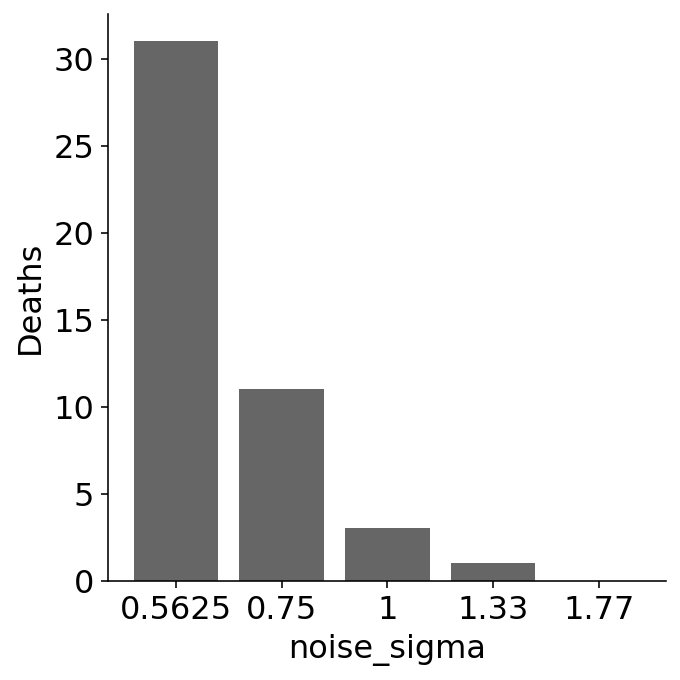

In [11]:
# Score
scores = []
for result in results:
    scores.append(num_death(result))   

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("noise_sigma")
plt.tight_layout()
sns.despine()


#### Add in code below to plot max score for different values of *noise_sigma*. Make sure your x-axis is labeled with noise_sigma, not p_scent. [6 pt]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

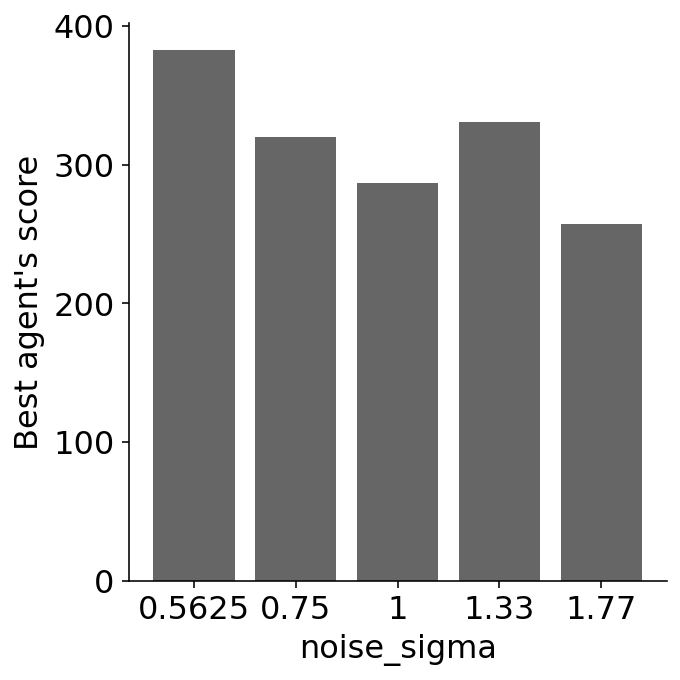

In [12]:
# Max Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m = []
for s in scores:
    m.append(np.max(s))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Best agent's score")
plt.xlabel("noise_sigma")
plt.tight_layout()
sns.despine()


#### Add in code below to plot average score and score frequency distributions for different values of *noise_sigma*. Make sure your x-axes are labeled with noise_sigma, not p_scent. [6 pt]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

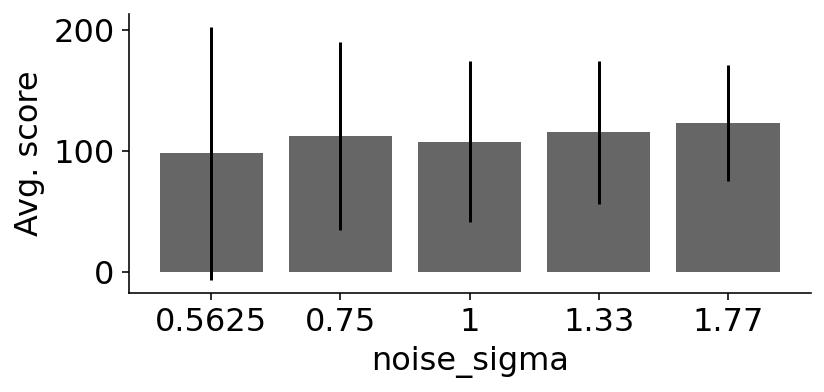

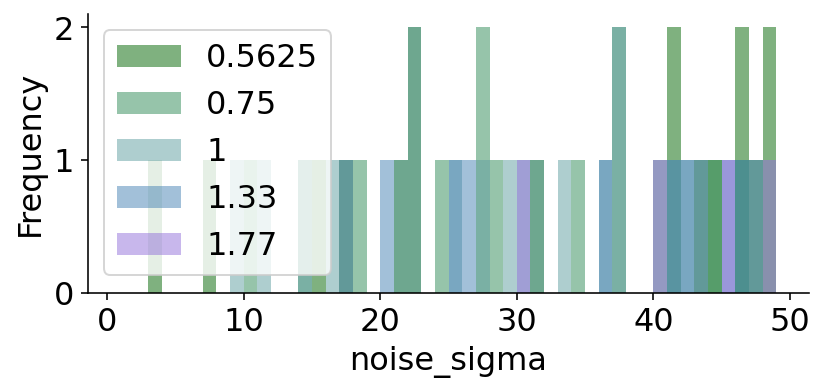

In [13]:
# Score
scores = []
for result in results:  
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(6, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.xlabel("noise_sigma")
plt.tight_layout()
sns.despine()

# Dists of means
fig = plt.figure(figsize=(6, 3))
for (i, s, c) in zip(names, scores, colors):
    plt.hist(s, label=i, color=c, alpha=0.5, bins=list(range(1,50,1)))
    plt.legend()
    plt.ylabel("Frequency")
    plt.xlabel("noise_sigma")
    plt.tight_layout()
    sns.despine()


### Question 2.1 [8 pt]

How does increasing *noise_sigma* impact our Info agent's performance? Explain why this particular pattern emerges in the results.

In [38]:
# Increasing noise_sigma increases the agents performance (the agent has a higher average score). This makes sense because when there is more noise in a sparse information environment, there will be more signals to the agent to move (because it is detecting noise even if there is no scent) which makes the agent more likely to find targets. 


### Question 2.2 [8 pt]

Re-run the simulations from this section, but now change the drift-rate from 1.0 to 0.75. How and why does this influence the agent's behavior (compared to the higher drift-rate)?

In [9]:
# At a lower drift rate, when there is low noise, the agent dies almost all of the time. This makes sense because when the drift rate is low, the environment is sparse, and there is low noise, there will be a very low amount of signals to move and information is accumulated slower than usual due to the low drift rate. So, it is less likely that the agent will make it to targets before it dies. 


### Question 3.3 [8 pt]

Now set the drift-rate back to 1.0 and reduce the boundary height from 3.0 to 1.5. Re-run the simulations in again. How and why does this influence the agent's behavior (compared to the higher boundary height)?

In [15]:
# Changing the boundary height makes it so that the agent is not as affected by the change in noise. As the noise increases, the average score stays approximately the same. This makes sense because a lower boundary height means that less information is needed to make a decition to move. So, even with little noise or information, the agent moves around and is likely to bump into a target. More noise does not change much because the agent is still moving and finding targets. This is not true with a high boundary height becuase in a sparse environment with little noise and a high boundary, the agent might not get enough information to make a decition to move and therefor will never find a target (and will then die).


**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Write Name(s) here*

**DUE:** 5pm ET, Oct. 28, 2022. Email the link to the completed notebook on your Github repository to the TA and me via Canvas.